# Improved Unet on ISIC

Importing libraries

In [1]:
import tensorflow as tf

In [2]:
from PIL import Image

In [3]:
from matplotlib import image
import matplotlib.pyplot as plt
import os
import numpy as np

In [4]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dense,Dropout,UpSampling2D,concatenate, Add, LeakyReLU
from tensorflow.keras.models import Model

In [5]:
from tensorflow.keras import datasets, layers, models, utils
import matplotlib.pyplot as plt
from tensorflow.keras.layers import concatenate

In [6]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import glob

In [7]:
#ls "ISIC2018_Task1-2_Training_Data/ISIC2018_Task1_Training_GroundTruth_x2"

Loading the Data

In [8]:
data_folder = "C:/Users/s4560340/Downloads/ISIC2018_Task1-2_Training_Data/"

inputs = glob.glob(data_folder + "ISIC2018_Task1-2_Training_Input_x2/*.jpg")
inputs.sort()
labels = glob.glob(data_folder + "ISIC2018_Task1_Training_GroundTruth_x2/*.png")
labels.sort()

assert(len(inputs) == len(labels))
for i in range(len(inputs)):
    x = np.asarray(Image.open(inputs[i]))
    y = np.asarray(Image.open(labels[i]))

Resizing images to 256x256

In [9]:
a = []
b = []
for i in range(len(inputs)):
    a_ = np.asarray(Image.open(inputs[i]).resize((256,256)))/255
    a.append(a_)
    b_ = np.asarray(Image.open(labels[i]).resize((256,256)))/255
    b.append(b_)

In [10]:
print(len(a))
print(len(b))

2594
2594


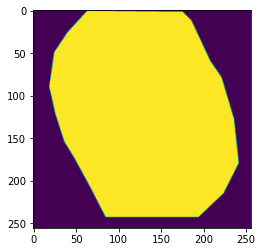

In [11]:
plt.imshow(b[45])

Splitting Data into train validation and test sets

In [12]:
length = len(a)
train_length = np.round(0.6*length)
validation_length = np.round(0.15*length)
test_length = np.round(0.25*length)

In [13]:
print(length)
print(train_length)
print(validation_length)
print(test_length)

2594
1556.0
389.0
648.0


In [14]:
train = a[0:int(train_length)]
train = np.asarray(train)
validation = a[int(train_length+1):int(train_length+validation_length+1)]
validation = np.asarray(validation)
test = a[int(train_length+validation_length):2593]
test = np.asarray(test)

In [15]:
print(length)
print(len(train))
print(len(validation))
print(len(test))

2594
1556
389
648


In [17]:
print(train.shape)
print(validation.shape)
print(test.shape)

(1556, 256, 256, 3)
(389, 256, 256, 3)
(648, 256, 256, 3)


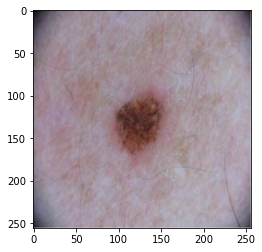

In [19]:
plt.imshow(train[9])

Splitting labels into Train Test and Validation

In [62]:
train_label = b[0:int(train_length)]
train_label = np.asarray(train_label)
validation_label = b[int(train_length+1):int(train_length+validation_length+1)]
validation_label = np.asarray(validation_label)
test_label = b[int(train_length+validation_length):2593]
test_label = np.asarray(test_label)

In [63]:
print(train_label.shape)
print(validation_label.shape)
print(test_label.shape)

(1556, 256, 256)
(389, 256, 256)
(648, 256, 256)


Adding a new axis to label data

In [64]:
train_labels = train_label[:, :, :, np.newaxis]
validation_labels = validation_label[:, :, :, np.newaxis]
test_labels = test_label[:, :, :, np.newaxis]

In [65]:
print(train_labels.shape)
print(validation_labels.shape)
print(test_labels.shape)

(1556, 256, 256, 1)
(389, 256, 256, 1)
(648, 256, 256, 1)


In [30]:
print(train.shape)
print(validation.shape)
print(test.shape)

(1556, 256, 256, 3)
(389, 256, 256, 3)
(648, 256, 256, 3)


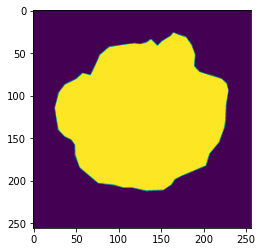

In [31]:
plt.imshow(train_labels[19])

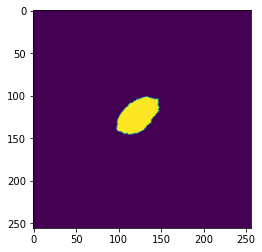

In [32]:
plt.imshow(train_labels[89])

In [33]:
train[89].shape

(256, 256, 3)

In [34]:
input__ = Input((256,256,3))

In [39]:
c1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(input__)
act_1 = LeakyReLU(alpha =0.01)(c1)

##first context module
context_mod1_layer1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(act_1)
act_2 = LeakyReLU(alpha =0.01)(context_mod1_layer1)
cont_dropoutlayer1 = Dropout(.3, input_shape=(2,))(act_2)
context_mod1_layer2 =  Conv2D(16, (3, 3),  strides=(1, 1), padding='same')(cont_dropoutlayer1)
act_3 = LeakyReLU(alpha =0.01)(context_mod1_layer2)

##element wise add
elem_add_1 = Add()([c1, act_3])

c2 = Conv2D(32, (3, 3),  strides=(2, 2), padding='same')(elem_add_1)
act_4 = LeakyReLU(alpha =0.01)(c2)

##second context module
context_mod2_layer1 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(act_4)
act_5 = LeakyReLU(alpha =0.01)(context_mod2_layer1)
cont_dropoutlayer2 = Dropout(.3, input_shape=(2,))(act_5)
context_mod2_layer2 =  Conv2D(32, (3, 3),  strides=(1, 1), padding='same')(cont_dropoutlayer2)
act_6 = LeakyReLU(alpha =0.01)(context_mod2_layer2)

##element wise add2
elem_add_2 = Add()([c2, act_6])

c3 = Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(elem_add_2)
act_7 = LeakyReLU(alpha =0.01)(c3)

##third context module
context_mod3_layer1 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(act_7)
act_8 = LeakyReLU(alpha =0.01)(context_mod3_layer1)
cont_dropoutlayer3 = Dropout(.3, input_shape=(2,))(act_8)
context_mod3_layer2 =  Conv2D(64, (3, 3),  strides=(1, 1), padding='same')(cont_dropoutlayer3)
act_9 = LeakyReLU(alpha =0.01)(context_mod3_layer2)

##element wise add3
elem_add_3 = Add()([c3, act_9])

c4 = Conv2D(128, (3, 3), activation='relu', strides=(2, 2), padding='same')(elem_add_3)
act_10 = LeakyReLU(alpha =0.01)(c4)

##fourth context module
context_mod4_layer1 = Conv2D(128, (3, 3),  strides=(1, 1), padding='same')(act_10)
act_11 = LeakyReLU(alpha =0.01)(context_mod4_layer1)
cont_dropoutlayer4 = Dropout(.3, input_shape=(2,))(act_11)
context_mod4_layer2 =  Conv2D(128, (3, 3), strides=(1, 1), padding='same')(cont_dropoutlayer4)
act_12 = LeakyReLU(alpha =0.01)(context_mod4_layer2)

##element wise add4
elem_add_4 = Add()([c4, act_12])


In [40]:
c5 = Conv2D(256, (3, 3),  strides=(2, 2), padding='same')(elem_add_4)
act_13 = LeakyReLU(alpha =0.01)(c5)

##fifth context module
context_mod5_layer1 = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(act_13)
act_14 = LeakyReLU(alpha =0.01)(context_mod5_layer1)
cont_dropoutlayer5 = Dropout(.3, input_shape=(2,))(act_14)
context_mod5_layer2 =  Conv2D(256, (3, 3),  strides=(1, 1), padding='same')(cont_dropoutlayer5)
act_15 = LeakyReLU(alpha =0.01)(context_mod5_layer2)

##element wise add5
elem_add_5 = Add()([c5, act_15])

##upsampling 1
up_1 = UpSampling2D(size=(2, 2))(elem_add_5)
upconv_1 = Conv2D(128, (3, 3),  strides=(1, 1), padding='same')(up_1)
act_16 = LeakyReLU(alpha =0.01)(upconv_1)

In [41]:
#concat 1 
con1 = concatenate([elem_add_4,act_16], axis = 3)

##localization module 1
loc3x3_1 = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(con1)
act_17 = LeakyReLU(alpha =0.01)(loc3x3_1)
loc1x1_1 = Conv2D(128, (1 ,1), strides=(1, 1), padding='same')(act_17)
act_17 = LeakyReLU(alpha =0.01)(loc1x1_1)

##upsampling 2
up_2 = UpSampling2D(size=(2, 2))(act_17)
upconv_2 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(up_2)
act_18 = LeakyReLU(alpha =0.01)(upconv_2)

#concat 2
con2 = concatenate([elem_add_3,act_18], axis = 3)

##localization module 2
loc3x3_2 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(con2)
act_19 = LeakyReLU(alpha =0.01)(loc3x3_2)
loc1x1_2 = Conv2D(64, (1 ,1), strides=(1, 1), padding='same')(act_19)
act_20 = LeakyReLU(alpha =0.01)(loc1x1_2)

##upsampling 3
up_3 = UpSampling2D(size=(2, 2))(act_20)
upconv_3 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(up_3)
act_21 = LeakyReLU(alpha =0.01)(upconv_3)

#concat 3 
con3 = concatenate([elem_add_2,act_21], axis = 3)

##localization module 3
loc3x3_3 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(con3)
act_22 = LeakyReLU(alpha =0.01)(loc3x3_3)
loc1x1_3 = Conv2D(32, (1 ,1), strides=(1, 1), padding='same')(loc3x3_3)
act_23 = LeakyReLU(alpha =0.01)(loc1x1_3)

##upsampling 4
up_4 = UpSampling2D(size=(2, 2))(act_23)
upconv_4 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(up_4)
act_24 = LeakyReLU(alpha =0.01)(upconv_4)

#concat 4
con4 = concatenate([elem_add_1,act_24], axis = 3)

c6 = Conv2D(32, (3, 3),  strides=(1, 1), padding='same')(con4)
act_25 = LeakyReLU(alpha =0.01)(c6)

In [42]:
##segmentation layers
seg_1 = Conv2D(1, (3, 3), strides=(1, 1), padding='same')(c6)
act_26 = LeakyReLU(alpha =0.01)(seg_1)

seg_2 = Conv2D(1, (3, 3),  strides=(1, 1), padding='same')(act_23)
act_27 = LeakyReLU(alpha =0.01)(seg_2)
#up_seg2 = UpSampling2D(size=(2, 2))(seg_2)

seg_3 = Conv2D(1, (3, 3), strides=(1, 1), padding='same')(act_20)
act_28 = LeakyReLU(alpha =0.01)(seg_3)
up_seg3 = UpSampling2D(size=(2, 2))(act_28)

##element wise add6
elem_add_5 = Add()([act_27, up_seg3])
up_add5 = UpSampling2D(size=(2, 2))(elem_add_5)

##element wise add7
elem_add_6= Add()([up_add5, act_26])
output = Conv2D(1, 1, activation = 'sigmoid')(elem_add_6)

In [43]:
model = Model(input__, output)

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_29 (LeakyReLU)      (None, 256, 256, 16) 0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 256, 256, 16) 2320        leaky_re_lu_29[0][0]             
______________________________________________________________________________________________

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
history = model.fit(train,train_labels,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(validation, validation_labels))

Train on 1556 samples, validate on 389 samples
Epoch 1/50
1556/1556 [==============================] - 26s 17ms/sample - loss: 0.4162 - accuracy: 0.8063 - val_loss: 0.2676 - val_accuracy: 0.9097
Epoch 2/50
1556/1556 [==============================] - 15s 10ms/sample - loss: 0.3652 - accuracy: 0.8654 - val_loss: 0.2525 - val_accuracy: 0.9211
Epoch 3/50
1556/1556 [==============================] - 15s 10ms/sample - loss: 0.3432 - accuracy: 0.8817 - val_loss: 0.2540 - val_accuracy: 0.9234
Epoch 4/50
1556/1556 [==============================] - 15s 10ms/sample - loss: 0.3210 - accuracy: 0.8933 - val_loss: 0.2415 - val_accuracy: 0.9124
Epoch 5/50
1556/1556 [==============================] - 15s 10ms/sample - loss: 0.3028 - accuracy: 0.9001 - val_loss: 0.2430 - val_accuracy: 0.9150
Epoch 6/50
1556/1556 [==============================] - 15s 10ms/sample - loss: 0.2806 - accuracy: 0.8983 - val_loss: 0.2021 - val_accuracy: 0.9228
Epoch 7/50
1556/1556 [==============================] - 15s 10ms/

Training loss vs Validation loss

389/389 - 1s - loss: 0.1344 - accuracy: 0.9426


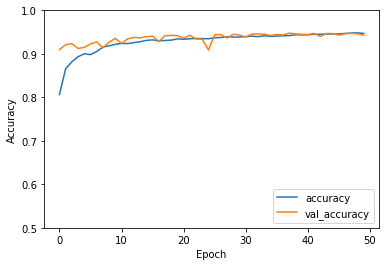

In [47]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(validation,  validation_labels, verbose=2)

Predicting test Data

In [48]:
prediction = model.predict(test)

In [49]:
prediction.shape

(648, 256, 256, 1)

Rounding the prediction Values

In [50]:
prediction_ = []
for i in prediction:
    prediction_.append(np.round(i))

In [51]:
prediction_

[array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], dtype=float32),
 array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
       

Changing test labels from double to float 

In [52]:
tf.dtypes.cast(test_labels, tf.float32)

<tf.Tensor: shape=(648, 256, 256, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
  

In [53]:
test_labels_ = tf.dtypes.cast(test_labels, tf.float32)

In [54]:
test_labels

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [55]:
test_labels_.shape

TensorShape([648, 256, 256, 1])

Plotting predicted images

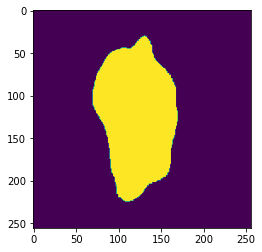

In [56]:
plt.imshow(prediction_[2][:,:,0])

Corresponding test image

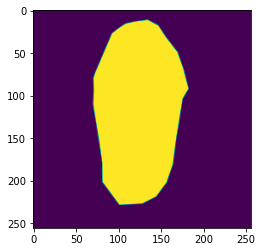

In [57]:
plt.imshow(test_labels_[2][:,:,0])

Calculating Dice Coefficient

In [58]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [59]:
dice_ = dice_coef(test_labels_, prediction_, smooth=1)

In [60]:
dice_

<tf.Tensor: shape=(), dtype=float32, numpy=0.8389326>